In [2]:
from keras.preprocessing.image import ImageDataGenerator

In [7]:
import numpy as np


class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.

        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.

        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.

        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.

        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [8]:


train_dir = "TEST"

batch_size = 5
validation_split = 0.3
img_height = 550
img_width = 550
epochs = 10

# Optional additional image augmentation with ImageDataGenerator.
input_imgen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0,
    shear_range=0.05,
    zoom_range=0,
    brightness_range=(1, 1.3),
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split)

# Create training and validation generator.
train_generator = MixupImageDataGenerator(generator=input_imgen,
                                          directory=train_dir,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height,
                                          subset='training')
validation_generator = input_imgen.flow_from_directory(train_dir,
                                                       target_size=(
                                                           img_height, img_width),
                                                       class_mode="categorical",
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       subset='validation')

print('training steps: ', train_generator.get_steps_per_epoch())
print('validation steps: ', validation_generator.samples // batch_size)


Found 23 images belonging to 2 classes.
Found 23 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
training steps:  4
validation steps:  1


In [15]:
import glob,os,cv2
files = glob.glob("TEST/*")
key2label = {k.split("\\")[-1]:v for k,v in zip(files,range(len(files)))}
label2key = {v:k for k,v in key2label.items()}
save_dir = "aug"
for i in range(1):
    d1 = next(train_generator)
    index = 0
    print(i)
    for k in range(d1[0].shape[0]):
        key = label2key[np.argmax(d1[1][k])]
        key = str(np.argmax(d1[1][k]))
        if not os.path.exists(f"{save_dir}/" + key):
            os.makedirs(f"{save_dir}/" + key,exist_ok=True)
        # cv2.imwrite(f"C:/repo/notebook/componetclf/test/{key}/{i}-{index}.jpg",d1[0][k,:,:,:])
        cv2.imwrite(f"{save_dir}/{key}/{i}-{index}.jpg", d1[0][k, :, :, :])
        index +=1

0


In [12]:
import matplotlib.pyplot as plt

In [4]:
import cv2

In [2]:
from keras.preprocessing.image import load_img,img_to_array,array_to_img,save_img

Using TensorFlow backend.


In [46]:
t = load_img("T.jpg")
b = load_img("bg1.jpg")
print(t.size,b.size)

(2976, 3968) (2976, 3968)


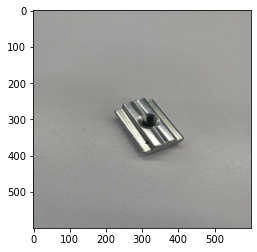

In [47]:
plt.imshow(t1)

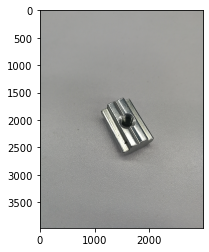

In [48]:
plt.imshow(t)

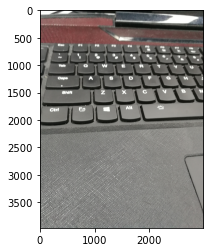

In [49]:
plt.imshow(b)

In [50]:

t1 = t.resize((600,600))
b1 = b.resize((600,600))
ti = img_to_array(t1)

tb = img_to_array(b1)
tb.resize((600,600,3))
print(ti.shape,tb.shape)

(600, 600, 3) (600, 600, 3)


In [51]:
ti = ti.astype(int)
tb = tb.astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


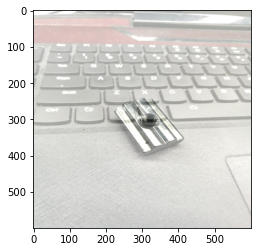

In [55]:
m = ti + tb*0.5
plt.imshow(m.astype(int))

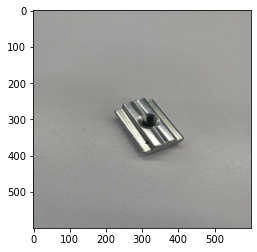

In [56]:
plt.imshow(ti)